## Meridian Marketing Mix Modeling: Python Tutorial

https://www.youtube.com/watch?v=dWWaY4dZPYQ&t=646s

https://colab.research.google.com/drive/1NLU7hjVl4hmfuJoIskH1UQPVFhIOkB1T?usp=sharing

A estatística Bayesiana é um ramo da estatística baseado no Teorema de Bayes, que atualiza a probabilidade de um evento com base em novas evidências. Diferente da estatística frequentista, que trata a probabilidade como a frequência de eventos ao longo do tempo, a abordagem Bayesiana interpreta a probabilidade como um grau de crença, que pode ser atualizado conforme novos dados são observados.

Ela é amplamente usada em aprendizado de máquina, previsão, tomada de decisões e inferência estatística em situações de incerteza.

A fórmula central da estatística Bayesiana é o Teorema de Bayes:

𝑃(𝐴∣𝐵)=𝑃(𝐵∣𝐴)⋅𝑃(𝐴)/𝑃(𝐵)

 
Explicação:

P(A∣B) → Probabilidade de A acontecer dado que B ocorreu (probabilidade posterior).

P(B∣A) → Probabilidade de B ocorrer dado que A aconteceu (verossimilhança).

P(A) → Probabilidade inicial de A ocorrer (probabilidade a priori).

P(B) → Probabilidade de B ocorrer (evidência).


In [26]:
# rodando no ambiente YouTube -> Anaconda

In [1]:
# no google colab
# Install meridian: from PyPI @ latest release
#!pip install --upgrade google-meridian[colab]

In [2]:
# prompt: git clone https://github.com/google/meridian.git

#!git clone https://github.com/google/meridian.git

In [3]:
# bibliotecas instaladas

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

2025-02-09 17:39:45.933568: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 17:39:45.934221: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-09 17:39:45.936642: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-09 17:39:45.943170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-09 17:39:45.955753: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

Your runtime has 16.4 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


# para rodar no drive do google mudar o tip de execução
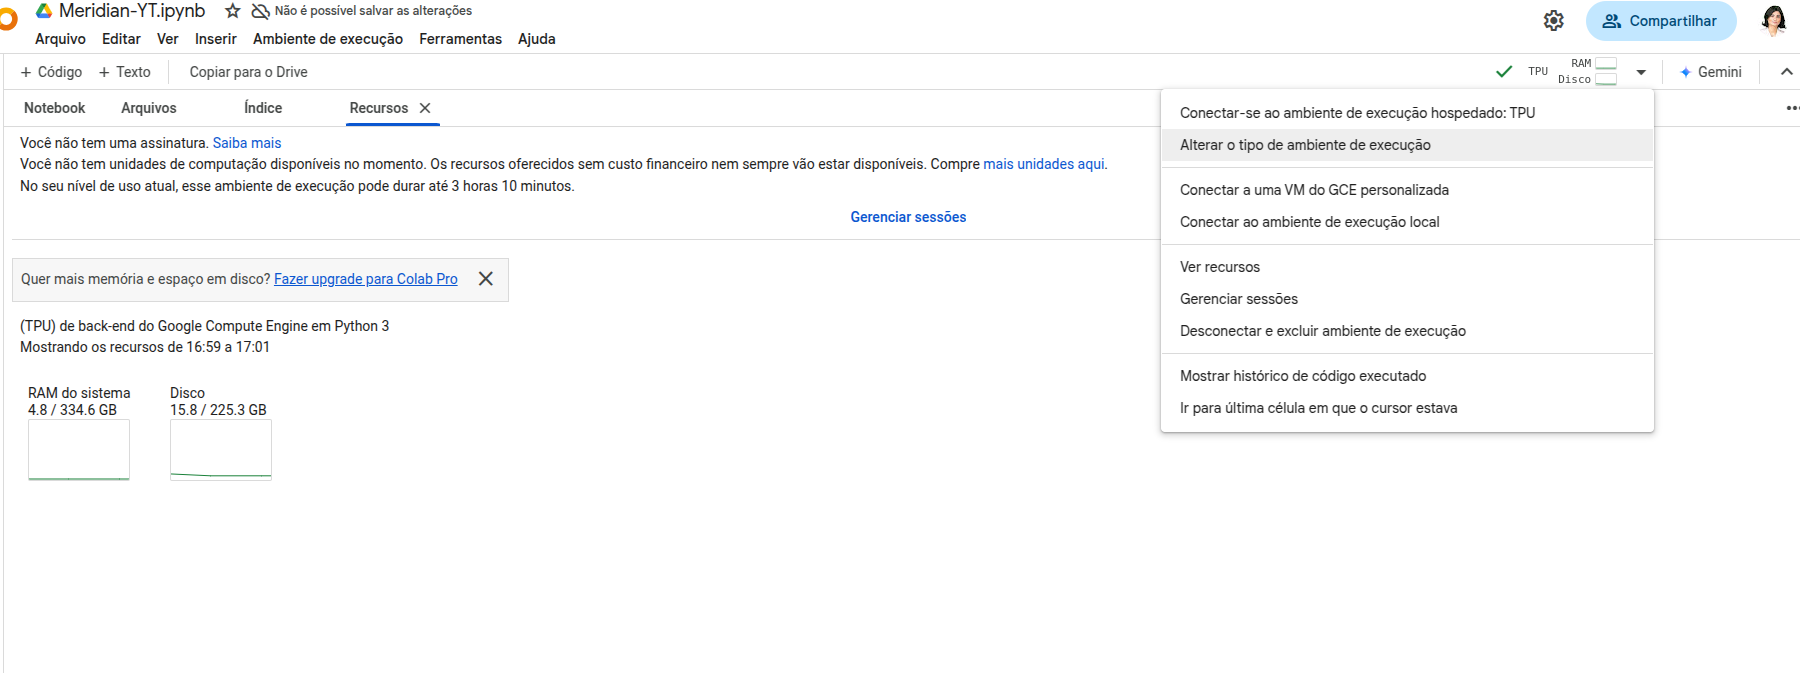


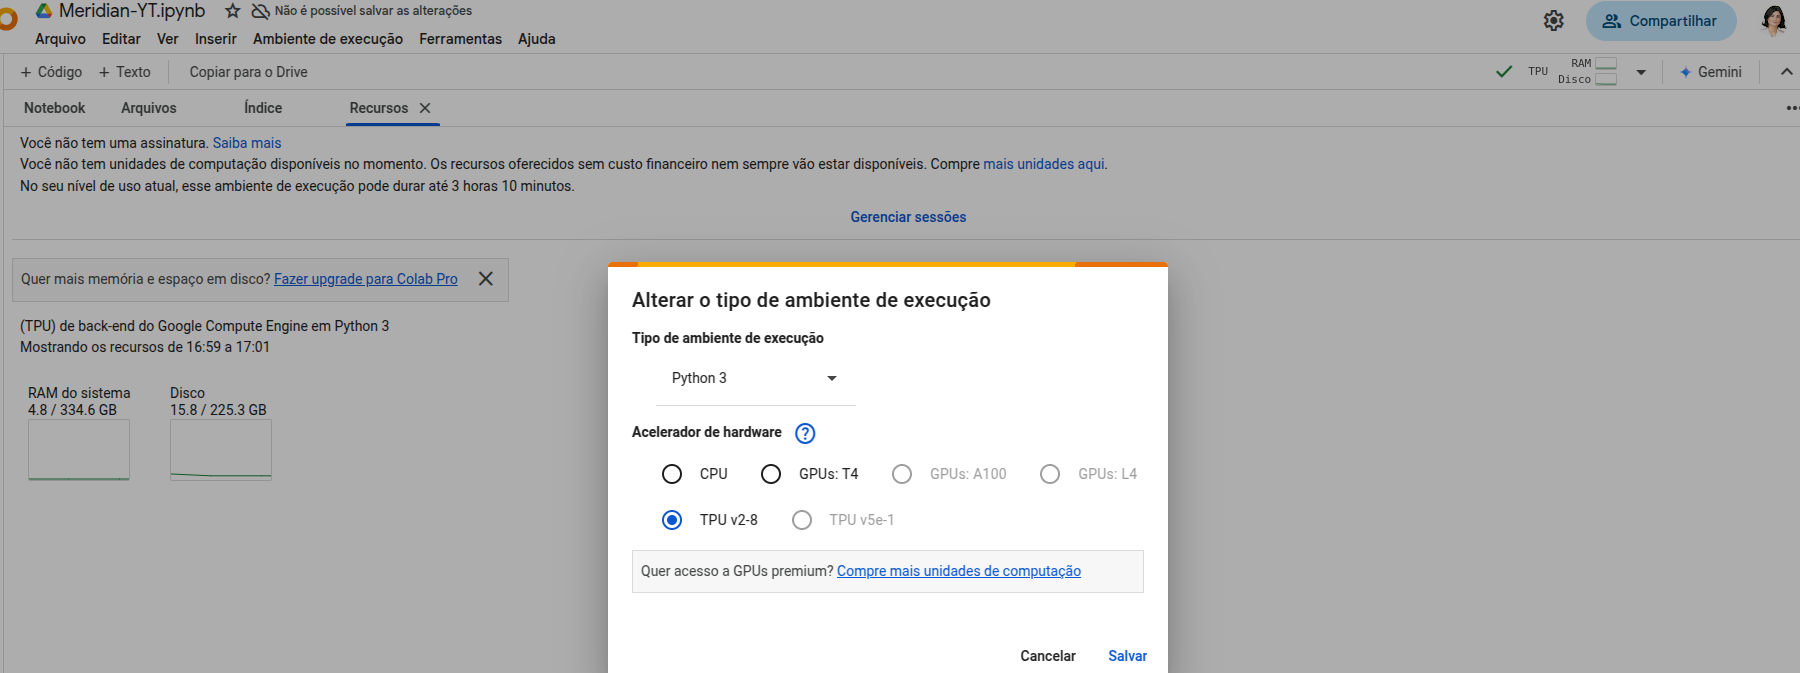

In [4]:
# mudar pra o TPU v2-8

In [5]:
coord_to_columns = load.CoordToColumns(
    time='time',
    geo='geo',
    controls=['GQV', 'Competitor_Sales'],
    population='population',
    kpi='conversions',
    revenue_per_kpi='revenue_per_conversion',
    media=[
        'Channel0_impression',
        'Channel1_impression',
        'Channel2_impression',
        'Channel3_impression',
        'Channel4_impression',
    ],
    media_spend=[
        'Channel0_spend',
        'Channel1_spend',
        'Channel2_spend',
        'Channel3_spend',
        'Channel4_spend',
    ],
    organic_media=['Organic_channel0_impression'],
    non_media_treatments=['Promo'],
)

In [6]:
correct_media_to_channel = {
    'Channel0_impression': 'Channel_0',
    'Channel1_impression': 'Channel_1',
    'Channel2_impression': 'Channel_2',
    'Channel3_impression': 'Channel_3',
    'Channel4_impression': 'Channel_4',
}
correct_media_spend_to_channel = {
    'Channel0_spend': 'Channel_0',
    'Channel1_spend': 'Channel_1',
    'Channel2_spend': 'Channel_2',
    'Channel3_spend': 'Channel_3',
    'Channel4_spend': 'Channel_4',
}

In [7]:
# importar do mapa

loader = load.CsvDataLoader(
    #csv_path="/content/meridian/meridian/data/simulated_data/csv/geo_all_channels.csv",
    csv_path="geo_all_channels.csv",
    kpi_type='non_revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=correct_media_to_channel,
    media_spend_to_channel=correct_media_spend_to_channel,
)
data = loader.load()

/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/data/load.py:1020: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[geo_column_name] = self.df[geo_column_name].replace(
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/data/load.py:201: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if (constants.GEO) not in self.dataset.dims.keys():
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/data/load.py:231: FutureWarning: The return type of `Dataset.dims` will be changed to return a set 

In [8]:
roi_mu = 0.2     # Mu for ROI prior for each media channel. (Mean)
roi_sigma = 0.9  # Sigma for ROI prior for each media channel. (Standard Deviation)
prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name=constants.ROI_M)
)
model_spec = spec.ModelSpec(prior=prior)

mmm = model.Meridian(input_data=data, model_spec=model_spec)

I0000 00:00:1739133587.993710   24509 service.cc:145] XLA service 0x2ff47550 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739133587.993755   24509 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1739133588.003565   24509 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [9]:
#%%time
#----------
#mmm.sample_prior(500)
#It tells the function to generate 500 samples from the prior distribution.x
#----------


#from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
#import time

# ... (rest of your imports and code) ...

#with tqdm(total=5*1000, desc="Training Progress") as pbar:  # Total iterations
#    def update_progress(current_iteration, total_iterations):
#        pbar.update(current_iteration)  # Update the progress bar
#----------
#----------
    # Remove progress_callback from the sample_posterior call
#    mmm.sample_posterior(
#        n_chains=5,
#        n_adapt=500,
#        n_burnin=500,
#        n_keep=1000,
#        parallel_iterations=100,
        # progress_callback=update_progress  # Remove this line
#    )
    # Manually update progress bar after sampling
#    pbar.update(5 * 1000)
#----------
#n_chains: Markov Chain Monte Carlo (MCMC) indipendent chains
#n_adapt: number of initial samples used to tune the sampling algorithm for better performance
#n_burnin: number of initial samples from each chain that are discarded
#n_keep: number of samples to keep from each chain after the burn-in phase. 
#These samples represent the posterior distribution of the model parameters and are used for inference.

In [10]:
from meridian.analysis import visualizer  
from tqdm.notebook import tqdm  # Para barra de progresso no Jupyter
import time
#reduzi para performar no computador com baixo suporte
#%%time

# Amostras da distribuição prévia (aumentado para evitar problemas)
mmm.sample_prior(100)

# Definir total de iterações para o progresso
total_iterations = 2 * 200  # 2 cadeias * 200 amostras

with tqdm(total=total_iterations, desc="Training Progress") as pbar:
    
    # Função para atualizar a barra de progresso
    def update_progress(current_iteration):
        pbar.update(current_iteration)

    # Ajustar a amostragem MCMC para um melhor equilíbrio entre desempenho e convergência
    mmm.sample_posterior(
        n_chains=2,         # Reduzido para 2 cadeias
        n_adapt=200,        # Mais iterações de adaptação para melhor performance
        n_burnin=200,       # Burn-in maior para descartar amostras ruins
        n_keep=200,         # Suficiente para boa inferência
        parallel_iterations=5  # Reduzido para evitar sobrecarga do processador
    )
    
    # Atualizar manualmente a barra de progresso
    pbar.update(total_iterations)




Training Progress:   0%|          | 0/400 [00:00<?, ?it/s]

2025-02-09 17:40:58.261904: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1739133659.206501   24509 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
W0000 00:00:1739133660.277288   24509 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert
2025-02-09 17:52:06.483964: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/arviz/data/inference_data.py:157: UserWarning: trace group is not defined in the InferenceData scheme
  warnings.warn(
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/arv

In [11]:

# número de chains => independente do chain 
# n_adapt para a performance. 
# n_burnin -> número 
# n_keep

## R-hat close to 1.0 indicate convergence. R-hat < 1.2 indicates approximate convergence and is a reasonable threshold for many problems.

In [12]:
# Lista de hat para a estimativa.

In [13]:
from meridian.analysis import visualizer

# 📊 Checar convergência
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()  # Se R-hat > 1.1, pode haver problema de convergência




/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

Each parameter in the plot corresponds to a specific aspect of your MMM model. Here's a general breakdown of the parameters commonly encountered in such models:

Alpha (
𝛼
α):

Represents the intercept of the model or the baseline contribution of the media channel (without interactions).
𝛼
𝑚
α
m
​
  and
𝛼
𝑜
𝑚
α
om
​
  might represent specific intercepts for different variables.

Beta (
𝛽
β):

Represents media elasticity. This measures the effect of media spend (e.g., TV, digital ads) on the outcome (e.g., sales).
𝛽
𝑔
𝑚
β
gm
​
 ,
𝛽
𝑔
𝑜
𝑚
β
gom
​
 ,
𝛽
𝑚
β
m
​
 , etc., might represent elasticities for different media channels or groups.

Gamma (
𝛾
γ):

Represents carryover effects or saturation parameters.
These parameters are often used in adstock transformations, capturing how the impact of media decays over time (e.g., long-term brand-building effects).

Eta (
𝜂
η):

Often represents the Hill transformation parameters for diminishing returns in MMM.
It controls the saturation level and steepness of the diminishing returns curve.

Sigma (
𝜎
σ):

Represents the standard deviation of the model residuals, indicating the uncertainty in your predictions.

Mu (
𝜇
μ):

Represents the mean of the response variable along with other contextual transformations.

Knot values:

Typically tied to spline-based models, representing flexible curves to capture nonlinear relationships (e.g., in spending vs. ROI).

Roi_m, Tau_g, Xi_c, Xi_n:

Likely represent channel-level ROI estimates (e.g., Return on Investment for media), time-dependent variables, or noise parameters depending on your specific model.


## Estimativa no baseline

## marketing return on investment (ROI)

## A KPI used as the response (revenue, customers, conversions, etc.)
# "Key Performance Indicators" — ou Indicadores-Chave de Desempenho

In [16]:
# calibração do investimento. 

In [17]:

## MMM alto valor alto risco

## 2. Assess the model's fit by comparing the expected revenue against the actual revenue.


In [22]:
mmm_summarizer = summarizer.Summarizer(mmm)
#save output
#from google.colab import drive
#drive.mount('/content/drive')


filepath = '/home/fabiene/Documentos/Fabiene/UDEMY_ML/MMM/MMM_Meridian'
start_date = '2021-01-25'
end_date = '2024-01-15'
mmm_summarizer.output_model_results_summary('2-summary_output_amostragoogle2.html', filepath, start_date, end_date)
#preview 2 pager
IPython.display.HTML(filename='2-summary_output_amostragoogle2.html')


/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype

Dataset,R-squared,MAPE,wMAPE
All Data,0.93,1%,1%


# Optimizing the budget

In [23]:
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

In [24]:
#filepath = '/content/drive/MyDrive'
optimization_results.output_optimization_summary('2-optimization_outputamostragoogle2.html', filepath)
IPython.display.HTML(filename='2-optimization_outputamostragoogle2.html')

/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype

Channel,Non-optimized spend,Optimized spend
Channel_3,40%,30%
Channel_4,22%,28%
Channel_0,18%,20%
Channel_1,14%,14%
Channel_2,6%,7%


In [25]:
## otimizar os resultados 

In [33]:
filepath2 = '/home/fabiene/Documentos/Fabiene/UDEMY_ML/MMM/MMM_Meridian/saved_mmm.pkl'
model.save_mmm(mmm, filepath2)